# Exploratory Analysis
---

## 1. Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import json

import nltk
from nltk.corpus import stopwords
from collections import Counter

## 2. Load Dataset

In [20]:
summary_df = pd.read_csv("./data/email_dataset.csv")

## 3. Statistics
Get ham, spam, and phish row count after cleanup.

In [21]:
summary_df["Email Type"].value_counts()

Email Type
ham      27617
spam     17171
phish     6977
Name: count, dtype: int64

Most data is legitimate (ham), so the model may overfit to it. Sampling balance may be needed.

### Text Characteristics (Before Cleaning)

In [ ]:
# Text length metrics
summary_df["char_count"] = summary_df["Email Text"].str.len()
summary_df["word_count"] = summary_df["Email Text"].apply(lambda x: len(x.split()))

# # Count URLs
url_pattern = r"http[s]?://\S+|www\.\S+"
summary_df["url_count"] = summary_df["Email Text"].apply(lambda x: len(re.findall(url_pattern, x)))

# Count special characters
summary_df["special_chars"] = summary_df["Email Text"].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

# Count uppercase words
summary_df["uppercase_words"] = summary_df["Email Text"].apply(lambda x: len([w for w in x.split() if w.isupper()]))

In [23]:
summary_df[["char_count", "word_count"]].describe()

,char_count,word_count
count,5.176500e+04,5.176500e+04
mean,2.052634e+03,4.254914e+02
std,7.499507e+04,1.552447e+04
min,1.000000e+00,0.000000e+00
25%,5.760000e+02,1.150000e+02
50%,8.820000e+02,1.740000e+02
75%,1.674000e+03,3.550000e+02
max,1.703669e+07,3.527576e+06


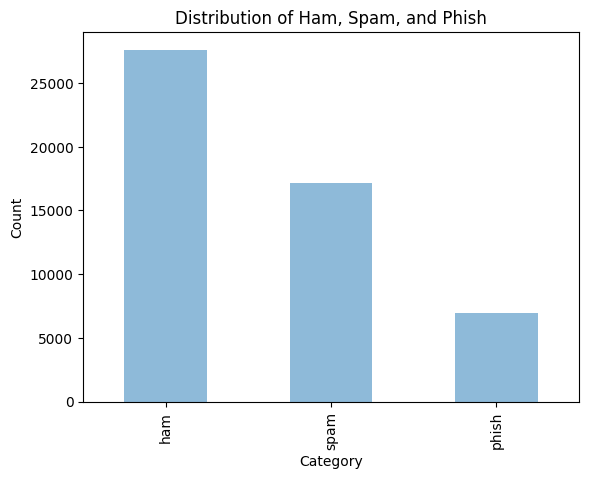

In [24]:
summary_df["Email Type"].value_counts().plot(kind='bar', alpha=0.5)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

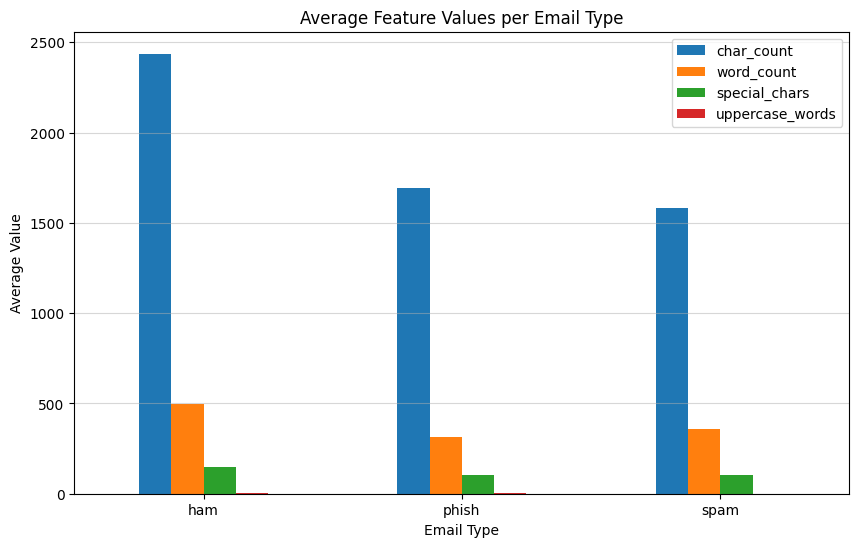

In [26]:
feature_cols = ["char_count", "word_count", "special_chars", "uppercase_words"]
grouped = summary_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6))
plt.title("Average Feature Values per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

In [27]:
# Ensure NLTK downloads (run once)
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/prokope/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/prokope/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
stop_words = set(stopwords.words("english"))

def get_top_words_clean(texts, n=20):
    """Return top n most common words."""
    all_words = []
    for txt in texts:
        all_words.extend(txt.split()) 
    return Counter(all_words).most_common(n)

Use `get_top_words` function to plot the most common words for each category.

Initialize `top_words` and populate with top words if not already populated (process takes some time when initialized).

In [32]:
categories = summary_df["Email Type"].unique().tolist()
top_words_clean = dict()

if Path("./top_words.json").exists():
    with open("top_words.json", 'r') as file:
        top_words_clean = json.load(file)

if top_words_clean.keys().isdisjoint(categories):
    for category in categories:
        words = get_top_words_clean(summary_df[summary_df["Email Type"] == category]["clean_text"])
        top_words_clean[category] = words

    with open("top_words.json", 'w') as file:
        json.dump(top_words_clean, file, indent=4)

top_words_clean

{'ham': [['enron', 79045],
  ['ect', 46326],
  ['would', 23472],
  ['subject', 23111],
  ['please', 22870],
  ['hou', 22222],
  ['new', 19854],
  ['com', 19445],
  ['university', 18471],
  ['http', 18368],
  ['one', 17335],
  ['language', 17147],
  ['company', 16646],
  ['said', 16111],
  ['information', 15953],
  ['e', 15138],
  ['also', 14743],
  ['may', 14430],
  ['time', 13398],
  ['energy', 12889]],
 'spam': [['e', 45000],
  ['enron', 44980],
  ['ubs', 42000],
  ['message', 29996],
  ['please', 28346],
  ['ivanhoe', 27000],
  ['subject', 26996],
  ['mail', 24000],
  ['com', 20992],
  ['cost', 19200],
  ['fred', 18000],
  ['original', 17996],
  ['sent', 17996],
  ['call', 15663],
  ['energy', 13500],
  ['final', 13500],
  ['schedule', 13500],
  ['type', 13500],
  ['jordan', 13500],
  ['pm', 13496]],
 'phish': [['â', 7647],
  ['email', 5308],
  ['http', 4852],
  ['free', 4382],
  ['com', 3942],
  ['get', 3886],
  ['company', 3885],
  ['please', 3875],
  ['information', 3846],
  ['mo

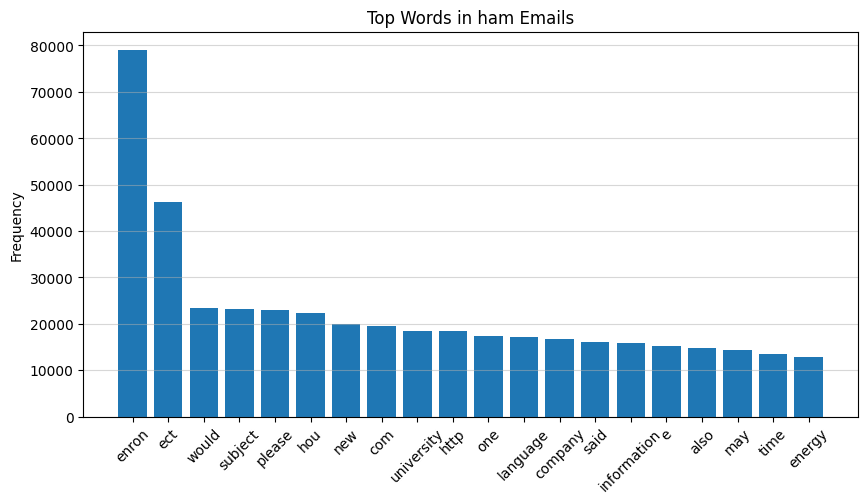

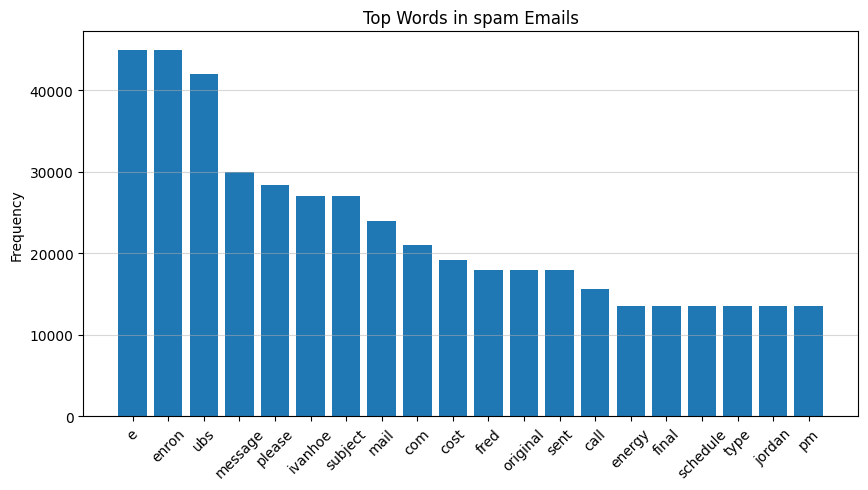

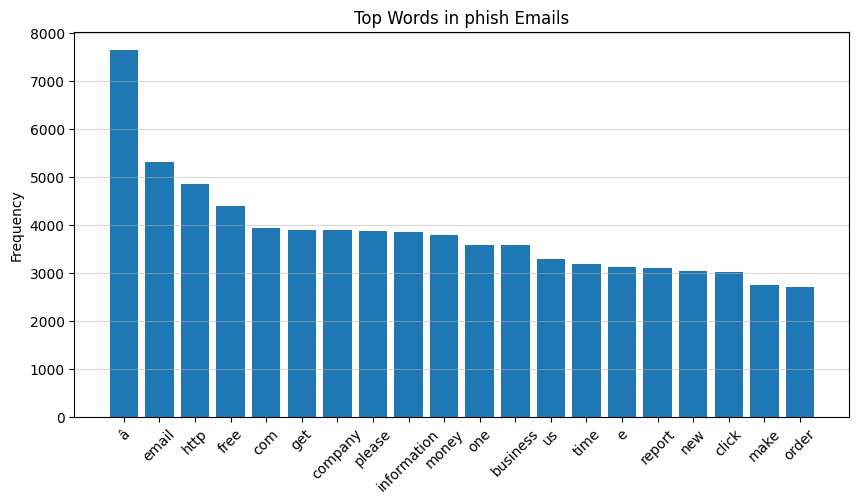

In [33]:
for category in categories:
    words, counts = zip(*top_words_clean[category])

    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.title(f"Top Words in {category} Emails")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.5)
    plt.show()